<a href="https://colab.research.google.com/github/Git053/DQN_pairtrading/blob/main/DQN_Pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random
import math
import gym
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import csv
from collections import deque

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
def formatPrice(n): #Print fomatted price
  return ("-$" if n < 0 else "$") + "{:0.2f}".format(abs(n))

def getStockDataVec(key): #returns stock data vector
  vec = []
  lines = open("data/" + key + ".txt", "r").read().splitlines()
  for line in lines[1:]:
    vec.append(float(line.split(",")[4]))

  return vec

def getStockVolVec(key): #returns stock volume vector
  vol = []
  lines = open("/content/drive/MyDrive/data/crypto_market_data_candlesticks" + key + ".txt", "r").read().splitlines()
  for line in lines[1:]:
    vol.append(float(line.split(",")[5]))

  return vol

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [4]:
import numpy as np
import random
import math, random 
import gym 
import numpy as np 


class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] #stock 1 open price
        self.Stock2Price=data2[timestep] #stock 2 open price
        self.Stock1Blnc=Bal_stock1 #stock 1 balance
        self.Stock2Blnc=Bal_stock2 #stock 2 balance
        self.open_cash=open_cash #cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        #self.volume1=volume1[timestep]
        #self.volume2=volume2[timestep]
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0
        #print("In portfolio func")
        #print("self.Stock1Price",self.Stock1Price, type(self.Stock1Price))
        #print("self.Stock1Blnc",self.Stock1Blnc[0], type(self.Stock1Blnc))

        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=(float(self.open_cash)/2)
        return (v1+v2+v3)
    
    def next_opening_price(self):
        return [data1[timestep+1], data2[timestep+1]]
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])
        #print("stock_5days=" + str(stock_5days))
        #print(stock_5days)

        #print(type(stock_5days))

        return stock_5days
    
    def reset(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        #self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.Stock1Price=data1[timestep] #stock 1 open price 
        self.Stock2Price=data2[timestep] #stock 2 open price 
        self.Stock1Blnc=Bal_stock1 #stock 1 balance 
        self.Stock2Blnc=Bal_stock2 #stock 2 balance 
        self.open_cash=open_cash #cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        self.portfolio_value=10000
        
    def getState(self):
        #print("In get state")
        res=[]
        res.append(self.Stock1Price) #stock 1 open price
        res.append(self.Stock2Price) #stock 2 open price
        res.append(self.Stock1Blnc) #stock 1 balance
        res.append(self.Stock2Blnc) #stock 2 balance
        res.append(self.open_cash) #cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)
        #res.append(self.volume1)
        #res.append(self.volume2)


        
        #print(res)
        res1=np.array([res])
        #print("res array"+np.array([res]))
        return res1

In [5]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size
    self.action_size = 5 #buy1, sell1, buy2, sell2, do nothing.
    self.memory = deque(maxlen=2000)
    self.inventory1 = []
    self.inventory2 = []
    self.model_name = model_name
    self.is_eval = is_eval
    self.gamma = 0.95 #discount factor (quantifies how much importance to give future rewards)
    self.epsilon = 1.0 #Eploration and Exploitation
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = load_model("/content/drive/MyDrive/IDS576/Project/models/" + model_name) if is_eval else self._model()
  
  def _model(self):
    model = Sequential()
    model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    return model
  
  def act(self, state):
    if not self.is_eval and random.random() <= self.epsilon:
      return random.randrange(self.action_size)
    options = self.model.predict(state)
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)

    minibatch = random.sample(self.memory, batch_size)

    for state, action, reward, next_state, done in mini_batch:
      target = reward

      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
      
      target_f = self.model.predict(state)
      target_f[0][action] = target
      self.model.fit(state, target_f, epochs=1, verbose=0)
    
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

In [6]:
stock_name1, stock_name2, episode_count, start_balance, training, test = 'aapl.us', 'amzn.us', 51, 10000, 1500, 500

In [7]:
pd_data1 = pd.read_csv('/content/drive/MyDrive/data/crypto_market_data_candlesticks/BTCUSDT10.csv', sep=",", header=0)
pd_data2 = pd.read_csv('/content/drive/MyDrive/data/crypto_market_data_candlesticks/ETHUSDT10.csv', sep=",", header=0)

In [8]:
pd_data1['Date']=pd.to_datetime(pd_data1['Date'], format='%Y/%m/%d')
pd_data2['Date']=pd.to_datetime(pd_data2['Date'], format='%Y/%m/%d')

In [9]:
pd_data2['Date'][0]

Timestamp('2020-01-01 00:00:00')

In [10]:
if (pd_data1['Date'][0] > pd_data2['Date'][0]):
  print("pd_data1 is older")
  pd_data1 = pd_data1[pd_data1.Date>=pd_data2['Date'][0]]
  pd_data1 = pd_data1.reset_index(drop=True)
else:
  print("pd_data1 is not older")
  pd_data2 = pd_data2[pd_data2.Date>=pd_data1['Date'][0]]
  pd_data2 = pd_data2.reset_index(drop=True)

pd_data1 is not older


In [11]:
import datetime
list1 = pd_data1['Date']
list2 = pd_data2['Date']
diff_pd1_data = list(set(list1) - set(list2))
diff_pd2_data = list(set(list2) - set(list1))
for k in range(len(diff_pd1_data)):
  pd1_date_format = diff_pd1_data[k].strftime('%Y-%m-%d 00:00:00')
  date_format_pd1 = datetime.datetime.strptime(pd1_date_format, '%Y-%m-%d 00:00:00')
  for i,j in enumerate(list1):
    if j == date_format_pd1:
      pd_data1 = pd_data1.drop([i])
pd_data1 = pd_data1.reset_index(drop=True)

for k in range(len(diff_pd2_data)):
  pd2_date_format = diff_pd2_data[k].strftime('%Y-%m-%d 00:00:00')
  date_format_pd2 = datetime.datetime.strptime(pd2_date_format, '%Y-%m-%d 00:00:00')
  for l,m in enumerate(list2):
    if m == date_format_pd2:
      pd_data2 = pd_data2.drop([l])
pd_data2 = pd_data2.reset_index(drop=True)

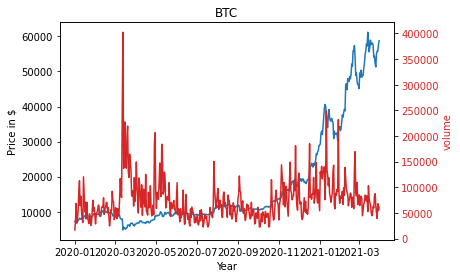

In [12]:
%matplotlib inline

x1 = np.array(pd_data1['Date'])
y1 = pd_data1['Open']
y12 = pd_data1['Volume']

plt.title("BTC")
plt.xlabel('Year')
plt.ylabel("Price in $")

plt.plot(x1,y1)

ax2 =  plt.twinx()

color = 'tab:red'
ax2.set_ylabel('volume', color=color)
ax2.plot(x1, y12, color=color)
ax2.tick_params(axis='y', labelcolor=color)

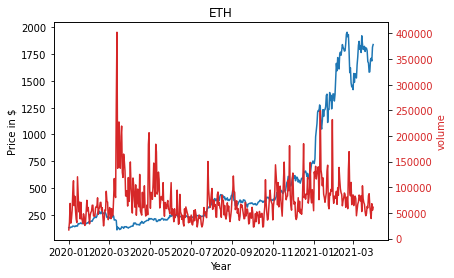

In [13]:
%matplotlib inline

x2 = np.array(pd_data2['Date'])
y2 = pd_data2['Open']
y22 = pd_data1['Volume']

plt.title("ETH")
plt.xlabel('Year')
plt.ylabel("Price in $")

plt.plot(x2,y2)

ax2 =  plt.twinx()

color = 'tab:red'
ax2.set_ylabel('volume', color=color)
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

In [14]:
pd_data1_train = pd_data1[0:training]
pd_data2_train = pd_data2[0:training]
pd_data1_test = pd_data1[training:training+test]
pd_data2_test = pd_data2[training:training+test]